In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline

In [25]:
! pip install shap
! pip install xgboost

     -------------------------------------- 462.3/462.3 kB 9.6 MB/s eta 0:00:00
     ---------------------------------------- 70.9/70.9 MB 5.8 MB/s eta 0:00:00


In [3]:
import shap

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap

from xgboost import XGBRegressor

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
df = pd.read_csv(r'F:\Janaki Data science folder\janu 2023\HomeLLC2023\JUPYTER FILES\all_data_file.csv')
print(df.shape)
print(df.columns)

(402, 15)
Index(['DATE', 'HomePriceIndex', 'ConsumerConfidenceIndex',
       'ConsumerSentiment', 'InterestRatesAndPriceIndexes',
       'CompositeLeadingIndicator', 'LaborCost', 'NationalUnemploymentRate',
       'HousingStarts', 'DebtToGDPRatio', 'GDPGrowthRate', 'Permit1Unit',
       'Permit2to4Unit', 'Permit5Unit', 'BuilderConfidence'],
      dtype='object')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          402 non-null    object 
 1   HomePriceIndex                402 non-null    float64
 2   ConsumerConfidenceIndex       402 non-null    float64
 3   ConsumerSentiment             402 non-null    float64
 4   InterestRatesAndPriceIndexes  402 non-null    float64
 5   CompositeLeadingIndicator     402 non-null    float64
 6   LaborCost                     402 non-null    float64
 7   NationalUnemploymentRate      402 non-null    float64
 8   HousingStarts                 402 non-null    int64  
 9   DebtToGDPRatio                402 non-null    float64
 10  GDPGrowthRate                 402 non-null    float64
 11  Permit1Unit                   402 non-null    int64  
 12  Permit2to4Unit                402 non-null    int64  
 13  Permi

In [6]:
df['DATE']= pd.to_datetime(df['DATE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DATE                          402 non-null    datetime64[ns]
 1   HomePriceIndex                402 non-null    float64       
 2   ConsumerConfidenceIndex       402 non-null    float64       
 3   ConsumerSentiment             402 non-null    float64       
 4   InterestRatesAndPriceIndexes  402 non-null    float64       
 5   CompositeLeadingIndicator     402 non-null    float64       
 6   LaborCost                     402 non-null    float64       
 7   NationalUnemploymentRate      402 non-null    float64       
 8   HousingStarts                 402 non-null    int64         
 9   DebtToGDPRatio                402 non-null    float64       
 10  GDPGrowthRate                 402 non-null    float64       
 11  Permit1Unit                   40

In [7]:
#drop permit 2to 4 and permit 5 , as the target "HomePriceIndex" is given for single unit.
df.drop(['Permit2to4Unit', 'Permit5Unit'], axis = 1, inplace=True)

In [8]:
df.describe()

,HomePriceIndex,ConsumerConfidenceIndex,ConsumerSentiment,InterestRatesAndPriceIndexes,CompositeLeadingIndicator,LaborCost,NationalUnemploymentRate,HousingStarts,DebtToGDPRatio,GDPGrowthRate,Permit1Unit,BuilderConfidence
count,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,4.020000e+02,402.000000
mean,147.014726,202.934030,85.865920,5938.843284,99.755448,0.773134,5.794527,1322.064677,79.477537,2.394627,9.576990e+05,51.582090
std,58.476753,48.226331,13.232528,1848.741588,1.324521,3.035825,1.743708,390.584211,23.240419,1.795762,3.305109e+05,19.175641
min,75.560000,126.100000,50.000000,2752.000000,92.590000,-4.400000,3.400000,478.000000,51.970000,-2.770000,3.370000e+05,8.000000
25%,89.480000,160.050000,76.400000,4228.000000,99.080000,-1.200000,4.500000,1080.000000,60.640000,1.840000,7.120000e+05,39.000000
50%,145.565000,204.750000,88.450000,6054.500000,99.870000,0.100000,5.450000,1345.500000,64.365000,2.680000,9.300000e+05,57.000000
75%,180.890000,236.085000,95.375000,7339.000000,100.720000,3.300000,6.700000,1580.500000,100.970000,3.520000,1.181750e+06,67.000000
max,304.820000,319.150000,112.000000,9522.000000,102.210000,7.600000,14.700000,2273.000000,134.840000,5.950000,1.798000e+06,90.000000


In [9]:


#check for outliers so create a df without date. 
dff=df.drop(columns=["DATE"])

Q1 = dff.quantile(0.25)
Q3 = dff.quantile(0.75)
IQR = Q3 - Q1
((dff < (Q1 - 1.5 * IQR)) | (dff > (Q3 + 1.5 * IQR))).sum() # gives no. of outliers



HomePriceIndex                   0
ConsumerConfidenceIndex          0
ConsumerSentiment                0
InterestRatesAndPriceIndexes     0
CompositeLeadingIndicator       12
LaborCost                        0
NationalUnemploymentRate         4
HousingStarts                    0
DebtToGDPRatio                   0
GDPGrowthRate                   24
Permit1Unit                      0
BuilderConfidence                0
dtype: int64

<AxesSubplot:xlabel='CompositeLeadingIndicator', ylabel='DATE'>

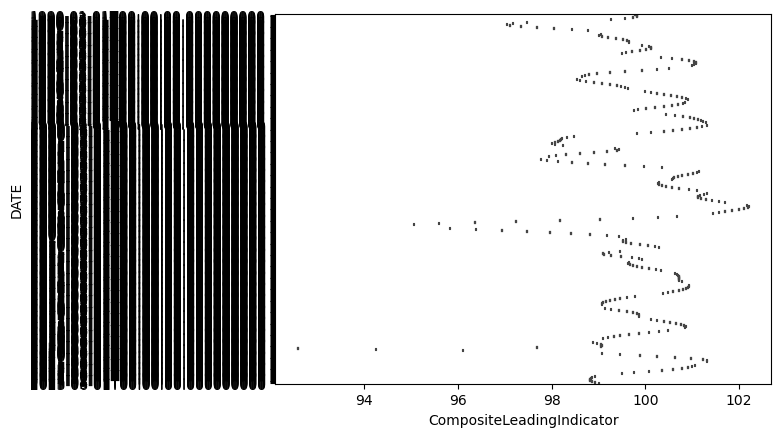

In [17]:
sns.boxplot(x='CompositeLeadingIndicator', y='DATE', data=df)


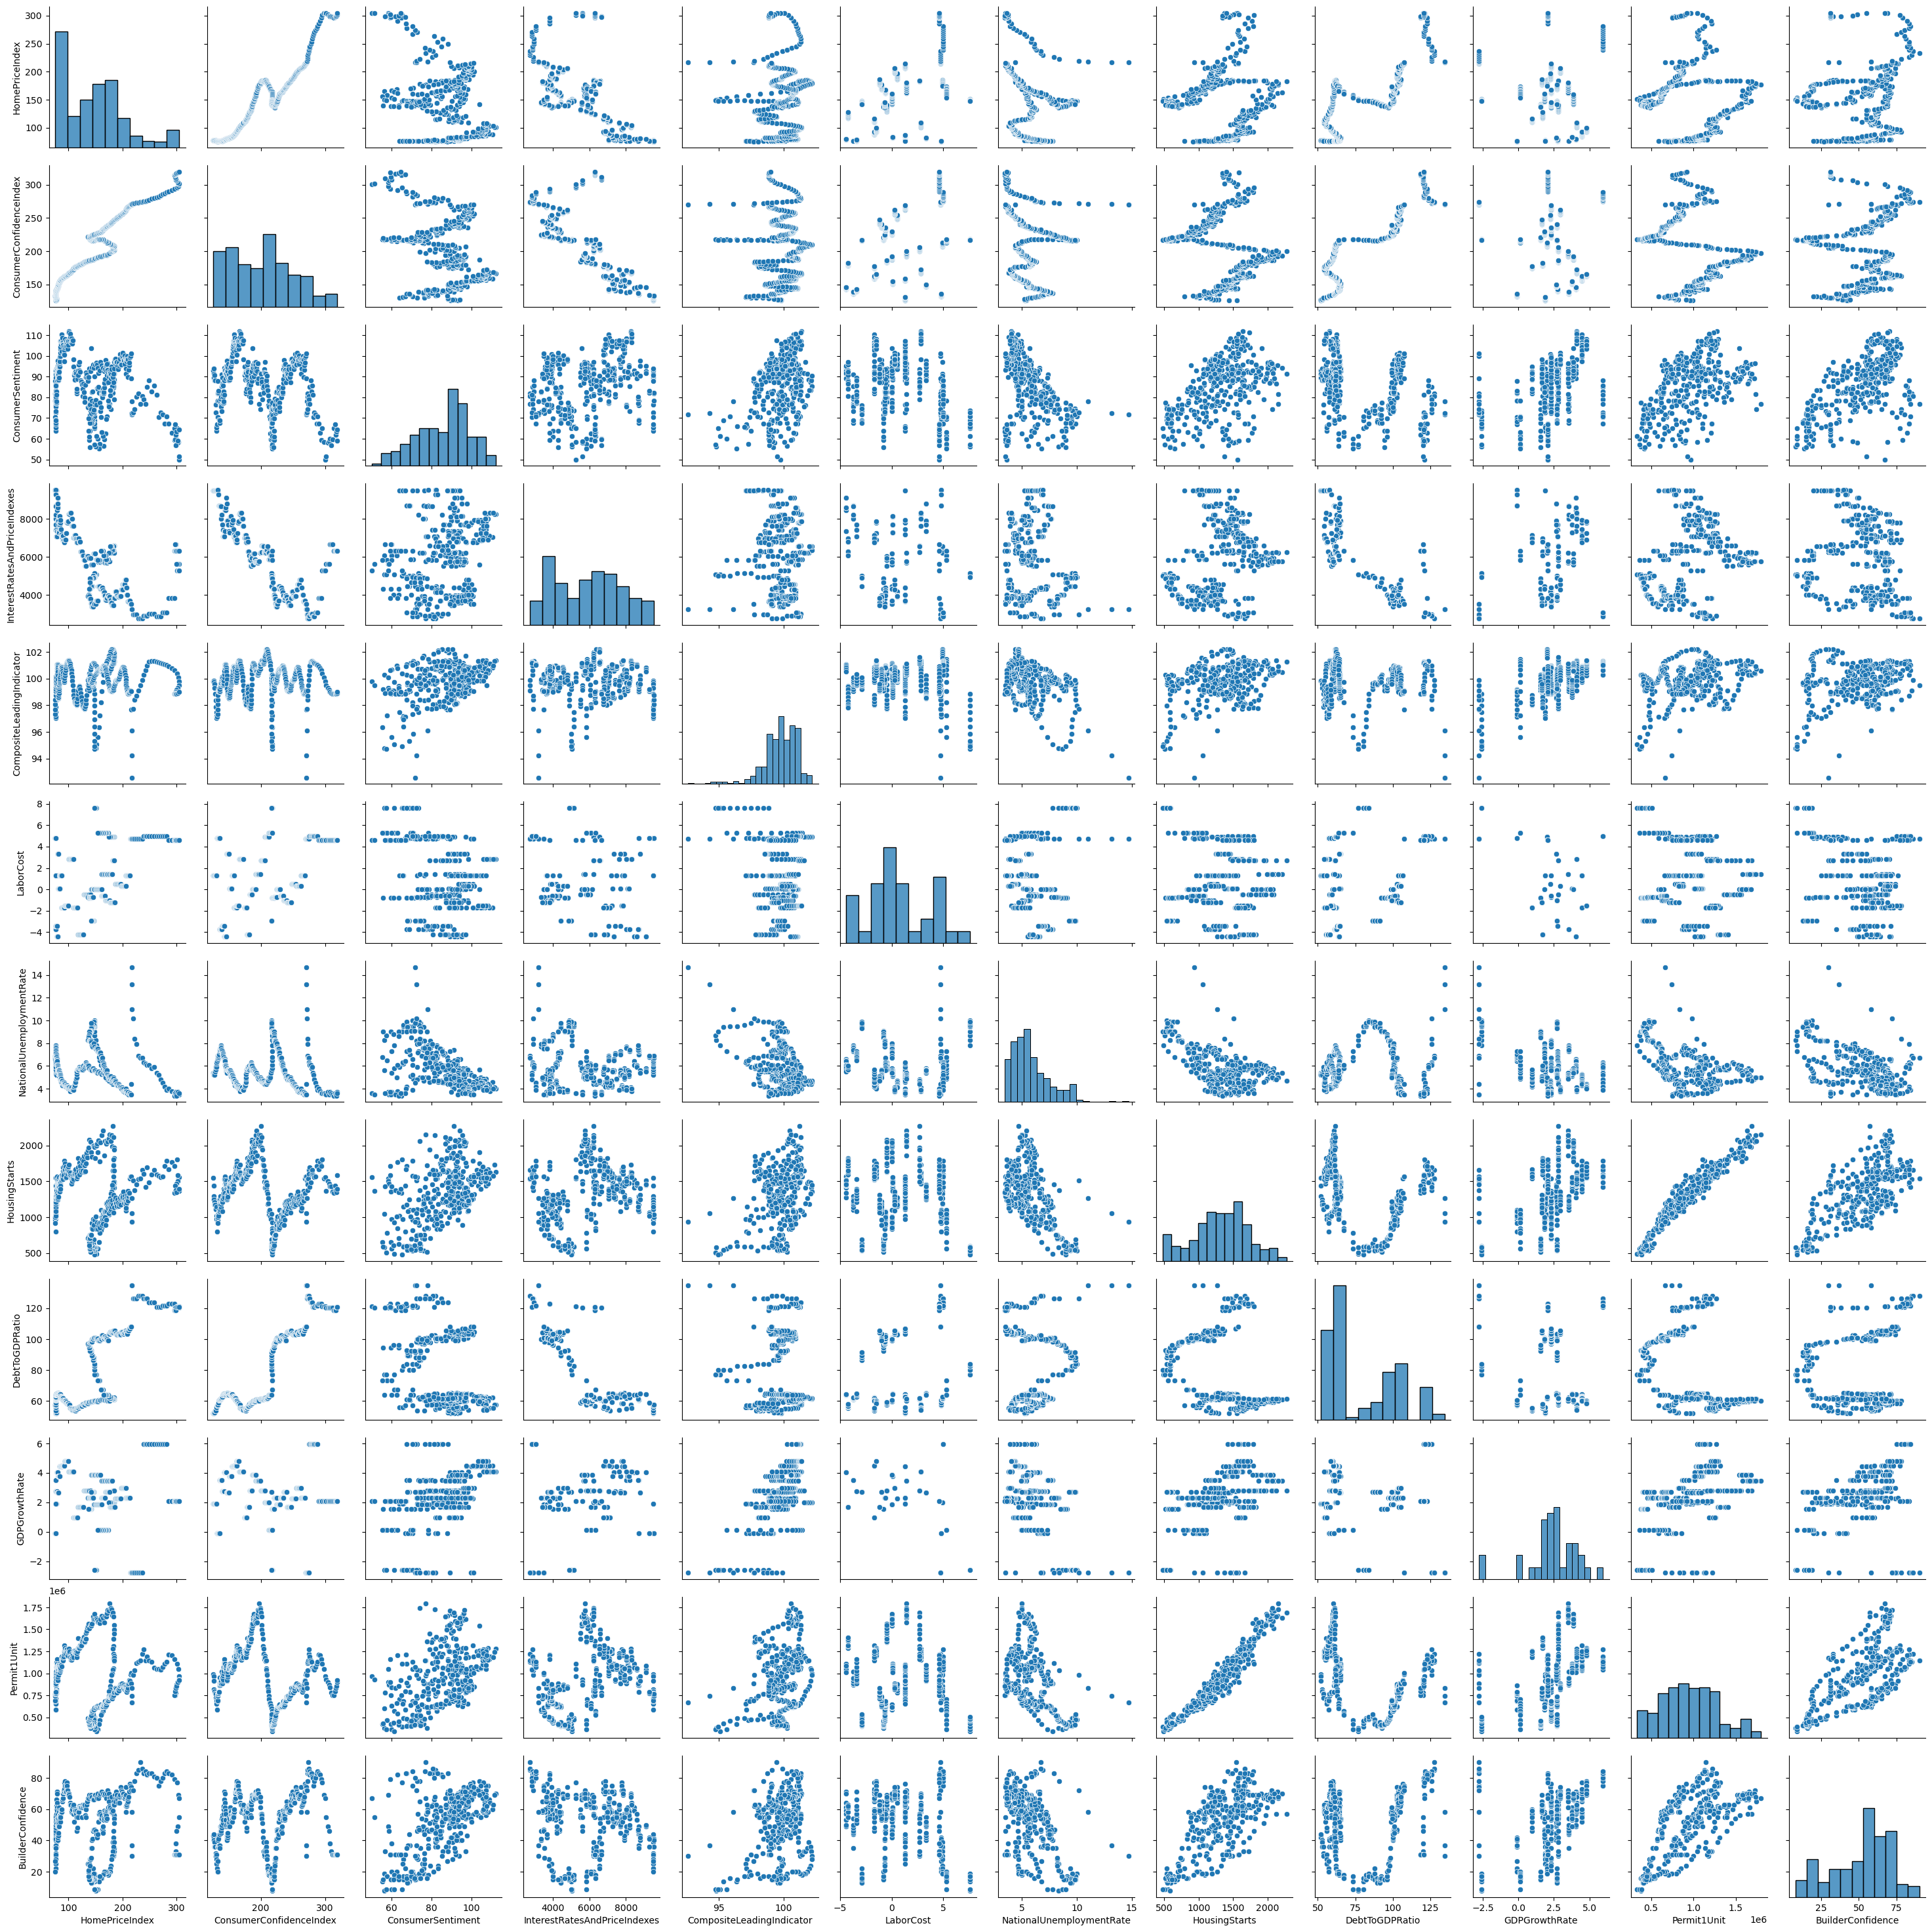

In [18]:
sns.pairplot(df)

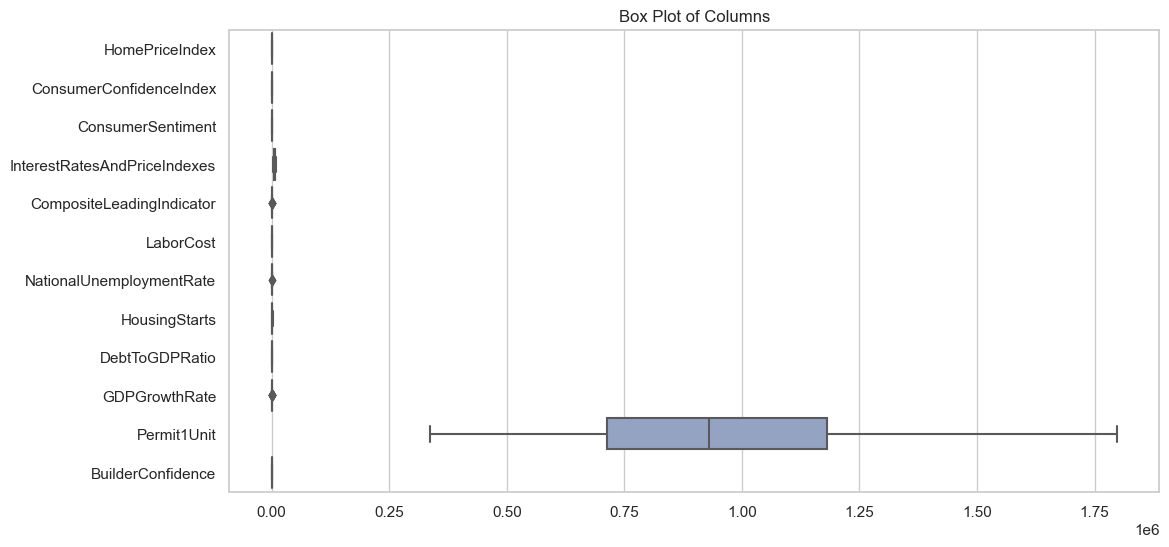

In [10]:
# Set the style of the plot (optional, but can improve aesthetics)
sns.set(style="whitegrid")

# Create a figure and axes
plt.figure(figsize=(12, 6))

# Create a box plot for each column
sns.boxplot(data=df, orient="h", palette="Set2")  # "h" for horizontal orientation

# Set the title
plt.title("Box Plot of Columns")

# Show the box plots
plt.show()

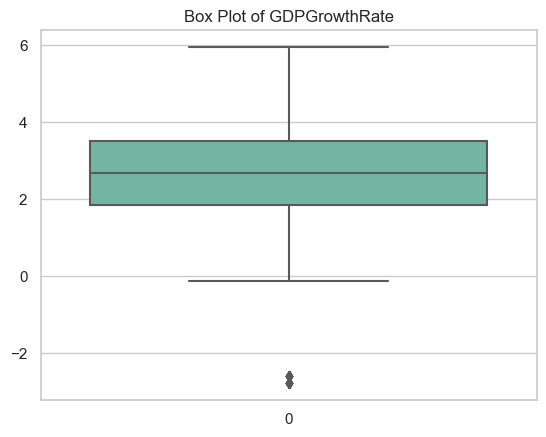

In [12]:
sns.boxplot(data=df['GDPGrowthRate'], palette="Set2")  # "h" for horizontal orientation

# Set the title
plt.title("Box Plot of GDPGrowthRate")

# Show the box plots
plt.show()

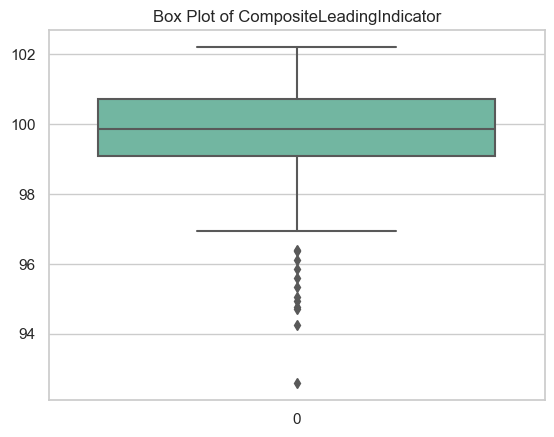

In [13]:


sns.boxplot(data=df['CompositeLeadingIndicator'], palette="Set2")  # "h" for horizontal orientation

# Set the title
plt.title("Box Plot of CompositeLeadingIndicator")

# Show the box plots
plt.show()


<AxesSubplot:>

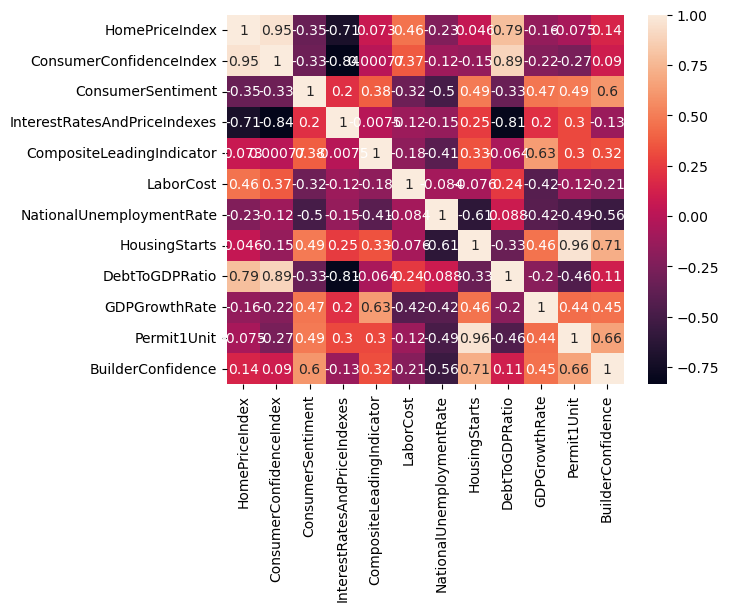

In [66]:
#to check how each feature is related with target(median sales price)
sns.heatmap(df.corr(),annot=True) 

# Linear Regression


In [99]:
from sklearn.preprocessing import StandardScaler ## standrard scalig 
scaler = StandardScaler() #initialise to a variable
scaler.fit(X_train,y_train) # we are finding the values of mean and sd from the td
X_train_scaled = scaler.transform(X_train) # fit (mean, sd) and then transform the training data
X_test_scaled = scaler.transform(X_test) # transform the test data 

In [101]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)

LinearRegression()

In [102]:
X.columns

Index(['ConsumerConfidenceIndex', 'ConsumerSentiment',
       'InterestRatesAndPriceIndexes', 'CompositeLeadingIndicator',
       'LaborCost', 'NationalUnemploymentRate', 'HousingStarts',
       'DebtToGDPRatio', 'GDPGrowthRate', 'Permit1Unit', 'BuilderConfidence'],
      dtype='object')

In [103]:
coeff_df = pd.DataFrame(regressor.coef_,['ConsumerConfidenceIndex', 'ConsumerSentiment',
       'InterestRatesAndPriceIndexes', 'CompositeLeadingIndicator',
       'LaborCost', 'NationalUnemploymentRate', 'HousingStarts',
       'DebtToGDPRatio', 'GDPGrowthRate', 'Permit1Unit', 'BuilderConfidence'], columns=['Coefficient'])
y_pred = regressor.predict(X_test_scaled)
coeff_df

,Coefficient
ConsumerConfidenceIndex,60.955484
ConsumerSentiment,-8.675500
InterestRatesAndPriceIndexes,8.106888
CompositeLeadingIndicator,3.221504
LaborCost,4.421297
NationalUnemploymentRate,-0.996055
HousingStarts,2.221966
DebtToGDPRatio,1.207567
GDPGrowthRate,0.604441
Permit1Unit,11.725068


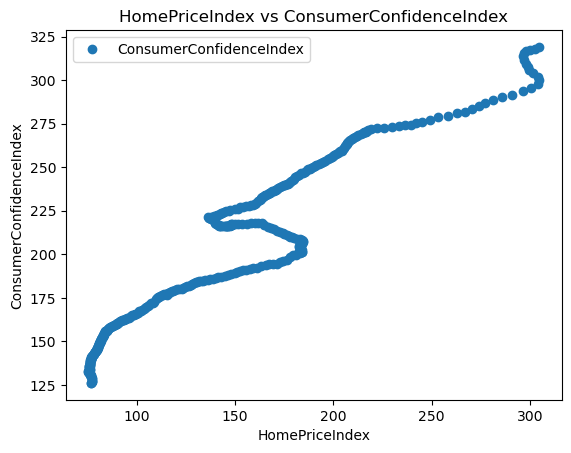

In [104]:

import matplotlib.pyplot as plt
df.plot(x='HomePriceIndex', y='ConsumerConfidenceIndex', style='o')
plt.title('HomePriceIndex vs ConsumerConfidenceIndex')
plt.xlabel('HomePriceIndex')
plt.ylabel('ConsumerConfidenceIndex')
plt.show()

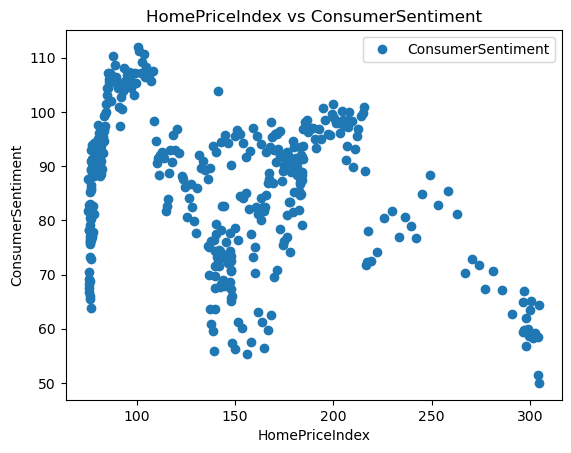

In [105]:
df.plot(x='HomePriceIndex', y='ConsumerSentiment', style='o')
plt.title('HomePriceIndex vs ConsumerSentiment')
plt.xlabel('HomePriceIndex')
plt.ylabel('ConsumerSentiment')
plt.show()

# XGB Model



In [67]:
#using dff since we will not be using timestamp in ML model
y=dff['HomePriceIndex']
X=dff.drop(['HomePriceIndex'], axis=1)

In [68]:
X.columns

Index(['ConsumerConfidenceIndex', 'ConsumerSentiment',
       'InterestRatesAndPriceIndexes', 'CompositeLeadingIndicator',
       'LaborCost', 'NationalUnemploymentRate', 'HousingStarts',
       'DebtToGDPRatio', 'GDPGrowthRate', 'Permit1Unit', 'BuilderConfidence'],
      dtype='object')

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [70]:
#calling model XGB and setting the no of trees to be 100
xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [71]:
xgb.feature_importances_


array([8.3132046e-01, 6.0613612e-03, 5.6874036e-04, 4.0019127e-03,
       1.2936375e-01, 1.6560968e-02, 1.1143972e-03, 6.9360868e-03,
       2.7498370e-03, 9.3169778e-04, 3.9077309e-04], dtype=float32)

In [86]:
# Get feature importances as a NumPy array
feature_importances = xgb.feature_importances_


In [87]:
# Create a DataFrame to display feature importances along with feature names
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by absolute importance values

importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_df)

                         Feature  Importance
0        ConsumerConfidenceIndex    0.831320
4                      LaborCost    0.129364
5       NationalUnemploymentRate    0.016561
7                 DebtToGDPRatio    0.006936
1              ConsumerSentiment    0.006061
3      CompositeLeadingIndicator    0.004002
8                  GDPGrowthRate    0.002750
6                  HousingStarts    0.001114
9                    Permit1Unit    0.000932
2   InterestRatesAndPriceIndexes    0.000569
10             BuilderConfidence    0.000391


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


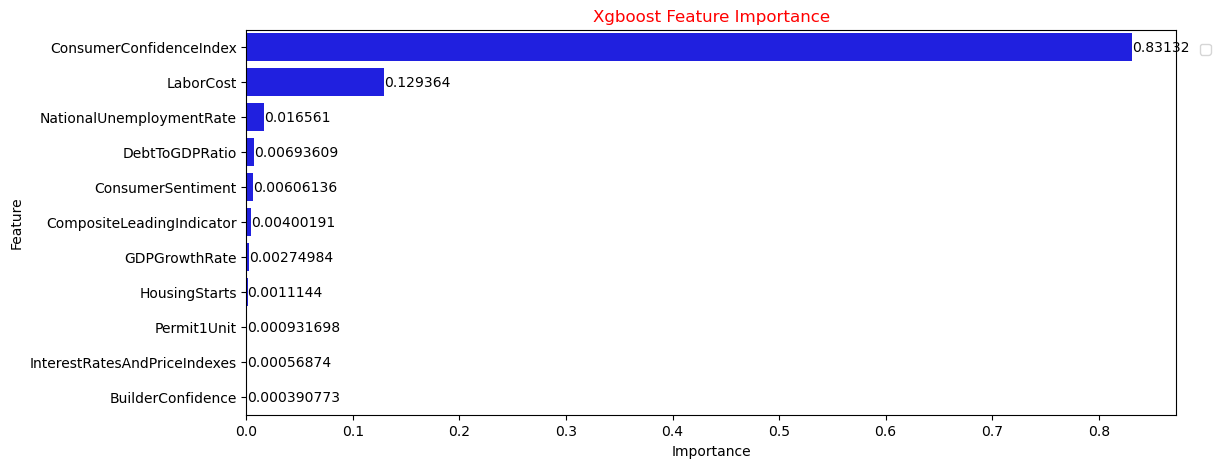

In [97]:


plt.figure(figsize=(12, 5))
fig=sns.barplot(x='Importance',y='Feature',data=importance_df, color='blue')
plt.title('Xgboost Feature Importance', loc='center',color='r')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=1)
for i in fig.containers:
  fig.bar_label(i,label_type='edge')
plt.show()



# Shap method

In [50]:
explainer = shap.TreeExplainer(xgb)

explainer

In [49]:
shap_values = explainer.shap_values(X_test)
shap_values


array([[ 1.27459021e+01, -2.42450625e-01, -6.51413441e-01, ...,
         4.88790311e-02, -2.30768800e-01,  3.70560959e-02],
       [ 1.42548676e+02,  4.57946634e+00,  1.99778661e-01, ...,
         1.65787280e-01,  7.58238494e-01,  1.87687218e-01],
       [ 2.77435112e+01, -2.72067785e-01, -7.10296452e-01, ...,
         1.82902694e-01, -1.04376964e-01,  2.57871896e-02],
       ...,
       [ 2.45997314e+01, -3.45414490e-01,  1.68185338e-01, ...,
         9.19536352e-02, -1.19437687e-01, -1.75422779e-03],
       [-6.82841415e+01, -5.80626130e-01,  2.13787317e-01, ...,
        -2.56703138e-01, -6.74683094e-01, -6.61252514e-02],
       [-6.49537888e+01, -9.58721161e-01,  2.20925599e-01, ...,
         4.36316356e-02,  4.36852574e-01,  1.55337453e-01]], dtype=float32)

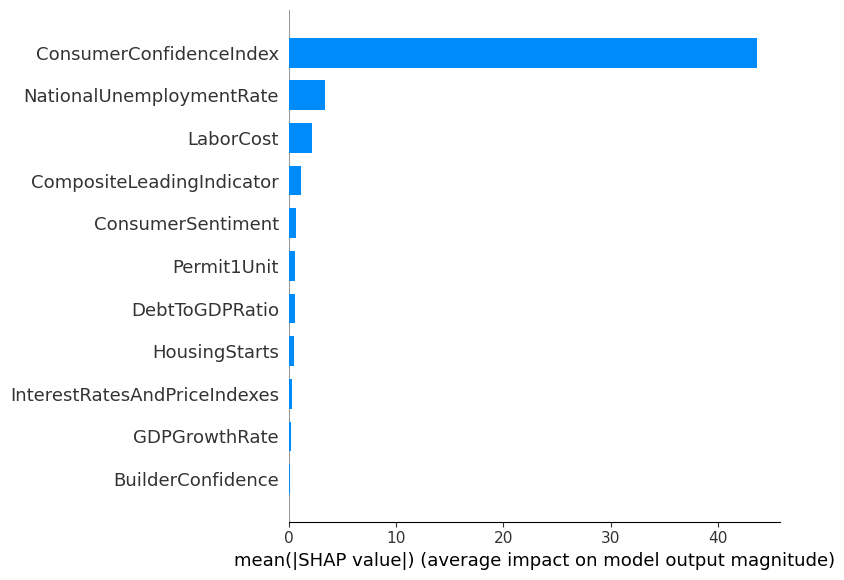

In [76]:
shap.summary_plot(shap_values, X_train.columns, plot_type="bar")


In [ ]:
https://mljar.com/blog/feature-importance-xgboost/

In [78]:
# Create an XGBoost model
model = XGBRegressor(n_estimators=100)

# Fit the model to the training data
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [83]:
# Get feature importances as a NumPy array
feature_importances = model.feature_importances_


In [85]:
# Create a DataFrame to display feature importances along with feature names
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by absolute importance values

importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_df)


                         Feature  Importance
0        ConsumerConfidenceIndex    0.831320
4                      LaborCost    0.129364
5       NationalUnemploymentRate    0.016561
7                 DebtToGDPRatio    0.006936
1              ConsumerSentiment    0.006061
3      CompositeLeadingIndicator    0.004002
8                  GDPGrowthRate    0.002750
6                  HousingStarts    0.001114
9                    Permit1Unit    0.000932
2   InterestRatesAndPriceIndexes    0.000569
10             BuilderConfidence    0.000391
